# Sparkify Project Workspace

This workspace contains a tiny subset (128MB) of the full dataset available (12GB). This notebook is used to explore a smaller subset with Spark before running on the cloud.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark import SparkFiles
from pyspark.sql.functions import avg, col, concat, count, desc, \
asc, explode, lit, min, max, split, stddev, udf, isnan, when, rank, \
log, sqrt, cbrt, exp
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, \
LogisticRegressionModel, RandomForestClassifier, \
RandomForestClassificationModel, GBTClassifier, \
GBTClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, \
PCA, RegexTokenizer, Tokenizer, StandardScaler, StopWordsRemover, \
StringIndexer, VectorAssembler, MaxAbsScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from time import time
import re
import numpy as np
import scipy
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import random
%matplotlib inline
random.seed(42)

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

## 1. Load and Clean Dataset

### 1.1. Load data

In [3]:
# Load from local source as a prototype
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### 1.2. Check for missing values

In [5]:
# Examine the number of missing values in each column
print(f"Total number of rows in the dataset: {df.count()}.\n")
missing_count_total = 0

for coln in df.columns:
    missing_count = df.filter((isnan(df[coln])) | (df[coln].isNull()) | (df[coln] == "")).count()
    
    if missing_count > 0:
        nan_count = df.filter(isnan(df[coln])).count()
        null_count = df.filter(df[coln].isNull()).count()
        empty_str = df.filter(df[coln] == "").count()
        print(f"{coln}: {missing_count} missing values. \
        {nan_count} NaN's; {null_count} Null's; {empty_str} empty strings.")
        missing_count_total += missing_count
        
if missing_count_total == 0:
    print("No missing values.")

Total number of rows in the dataset: 286500.

artist: 58392 missing values.         0 NaN's; 58392 Null's; 0 empty strings.
firstName: 8346 missing values.         0 NaN's; 8346 Null's; 0 empty strings.
gender: 8346 missing values.         0 NaN's; 8346 Null's; 0 empty strings.
lastName: 8346 missing values.         0 NaN's; 8346 Null's; 0 empty strings.
length: 58392 missing values.         0 NaN's; 58392 Null's; 0 empty strings.
location: 8346 missing values.         0 NaN's; 8346 Null's; 0 empty strings.
registration: 8346 missing values.         0 NaN's; 8346 Null's; 0 empty strings.
song: 58392 missing values.         0 NaN's; 58392 Null's; 0 empty strings.
userAgent: 8346 missing values.         0 NaN's; 8346 Null's; 0 empty strings.
userId: 8346 missing values.         0 NaN's; 0 Null's; 8346 empty strings.


#### Missing values in `userId` and `sessionId`

In [6]:
# Remove rows that have NaN in either userId or sessionId
num_rows = df.count()
print(f"There are {df.count()} rows in the dataset.")
df = df.dropna(how='any', subset=['userId', 'sessionId'])
print(f"There are {num_rows - df.count()} NaN's in either userId or sessionId. These rows are dropped.")

There are 286500 rows in the dataset.
There are 0 NaN's in either userId or sessionId. These rows are dropped.


In [7]:
# Preview the values of useId
df.select(['userId']).dropDuplicates().orderBy(df['userId']).show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



An `userId` of empty string looks suspicious. To figure out what's going on, I'm going to look at the `page` events for empty `userId`'s in comparison with all `userId`'s.

In [8]:
# Create a view to run SQL queries
df.createOrReplaceTempView("df_table")

In [9]:
# page events of users whose userId IS an empty string
spark.sql(
    '''
    SELECT DISTINCT page
    FROM df_table
    WHERE userId == ""
    '''
).show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [10]:
# page events of users whose userId is NOT an empty string
spark.sql(
    '''
    SELECT DISTINCT page
    FROM df_table
    EXCEPT
    SELECT DISTINCT page
    FROM df_table
    WHERE userId == ""
    '''
).show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|             Upgrade|
|      Submit Upgrade|
+--------------------+



An `userId` of empty string likely represents user(s) who are in the middle of or prior to sign-in or registration. Therefore, the rows corresponding to empty `userId` are dropped.

In [11]:
# Drop rows that have empty userId
df = df.filter(df['userId'] != "")

Because `sessionId` column is numeric, we don't need to worry about empty string problem for this column.

In [12]:
# Check the number of missing values in userId and sessionId
print("Number of missing values:")
for coln in ['userId', 'sessionId', 'firstName', 'gender', 'lastName', 'location', 'registration', 'userAgent']:
    missing_count = df.filter((isnan(df[coln])) | (df[coln].isNull()) | (df[coln] == "")).count()
    print(f"    {coln}: {missing_count} missing values.")

Number of missing values:
    userId: 0 missing values.
    sessionId: 0 missing values.
    firstName: 0 missing values.
    gender: 0 missing values.
    lastName: 0 missing values.
    location: 0 missing values.
    registration: 0 missing values.
    userAgent: 0 missing values.


#### Missing values in `artist`, `length`, `song`

In [13]:
# page events of null artist values
df.filter(df['artist'].isNull()).select(df['page']).dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [14]:
# page events of NOT null artist values
df.filter(df['artist'].isNotNull()).select(df['page']).dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



It seems that only page event "NextSong", i.e. playing a song, has corresponding artist information, which makes sense. This should apply for each of the `artist`, `length`, and `song` columns

In [15]:
# Check the number of missing values of artist, length, song columns when page event is "NextSong"
df_song = df.filter(df['page'] == "NextSong")
print("When page event is 'NextSong':")
for coln in ['artist', 'length', 'song']:
    missing_count = df_song.filter((isnan(df[coln])) | (df[coln].isNull()) | (df[coln] == "")).count()
    print(f"    {coln}: {missing_count} missing values.")

When page event is 'NextSong':
    artist: 0 missing values.
    length: 0 missing values.
    song: 0 missing values.


## 2. Exploratory Data Analysis (EDA)

Perform EDA using a small subset of the full dataset.

In [16]:
# Number of unique userId's to be sampled for exploratory data analysis
user_sample_size = 250

# Unique userId's from the full dataset
users = [row.userId for row in df.select('userId').dropDuplicates().collect()]

# Sample userId's
if len(users) > user_sample_size:
    user_sample = list(np.random.choice(users, size=user_sample_size, replace=False))
else:
    user_sample = list(np.copy(users))

# Create subset of the full dataset
df_sub = df.filter(df['userId'].isin(user_sample))

### 2.1. Overview of numerical columns

A quick look at descriptive statistics.

In [17]:
# Numerical columns (except for sessionId)
num_cols = ['itemInSession', 'registration', 'status', 'ts', 'length']

In [18]:
# Describe numerical columns (except for sessionId)
df_sub.select(num_cols).describe().show()

+-------+------------------+--------------------+------------------+--------------------+-----------------+
|summary|     itemInSession|        registration|            status|                  ts|           length|
+-------+------------------+--------------------+------------------+--------------------+-----------------+
|  count|            278154|              278154|            278154|              278154|           228108|
|   mean|114.89918174824018|1.535358834084427...|209.10321620397335|1.540958915431871...|249.1171819778458|
| stddev|  129.851729399489| 3.291321616327586E9|30.151388851328214|1.5068287123306298E9|99.23517921058361|
|    min|                 0|       1521380675000|               200|       1538352117000|          0.78322|
|    max|              1321|       1543247354000|               404|       1543799476000|       3024.66567|
+-------+------------------+--------------------+------------------+--------------------+-----------------+



In [19]:
# Possible values of status
coln = 'status'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'status':
[307, 404, 200]


`status` values do not have continuous meaning, so I will consider column `status` as a categorical variable.

### 2.2. Overview of non-numerical columns

A quick look at the possible categories.

In [20]:
# Non-numerical columns (except for userId)
cat_cols = ['artist', 'auth', 'firstName', 'lastName', 'gender', 'level', 'location',
            'method', 'page', 'song', 'userAgent']

In [21]:
# Possible values of auth
coln = 'auth'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'auth':
['Cancelled', 'Logged In']


In [22]:
# Possible values of gender
coln = 'gender'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'gender':
['F', 'M']


In [23]:
# Possible values of level
coln = 'level'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'level':
['free', 'paid']


In [24]:
# Possible values of method
coln = 'method'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'method':
['PUT', 'GET']


In [25]:
# Possible values of page
coln = 'page'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'page':
['Cancel', 'Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert', 'Logout', 'Save Settings', 'Cancellation Confirmation', 'About', 'Settings', 'Add to Playlist', 'Add Friend', 'NextSong', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade']


In [26]:
# Possible values of userAgent
coln = 'userAgent'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()[:10]])

Possible values of 'userAgent':
['"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', '"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', 'Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0', 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0', 'Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0)', '"Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.198

In [27]:
# A status of 404 corresponds to a page event "Error"
df_sub.select(['status', 'page']).where(df_sub['status']==404).dropDuplicates().show()

+------+-----+
|status| page|
+------+-----+
|   404|Error|
+------+-----+



### 2.3. Define churn

Create a column `Churn` to use as the label for the model. I decided to use the `Cancellation Confirmation` events to define churn, which happen for both paid and free users. Here I define churn as no longer using any music service, either as a free user or as a paid user.

In [28]:
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_sub = df_sub.withColumn("churned", flag_churn_event("page"))

In [29]:
# Calculate percentage of users who churned
pctg = df_sub.groupBy('userId').agg({'churned': 'sum'})\
    .select(avg('sum(churned)')).collect()[0]['avg(sum(churned))']
print(f"{round(pctg*100, 1)}% users have churned.")

23.1% users have churned.


In [30]:
# Calculate flags of churn
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)

# 1 means the user has already churned at this timestamp
df_sub = df_sub.withColumn("churnPhase", Fsum('churned').over(windowval))

# 1 means the user is a churn user
df_sub = df_sub.withColumn("churnUser", max('churned').over(Window.partitionBy("userId")))

### 2.4. Explore data
Analyze the behavior for users who stayed vs users who churned.

In [31]:
# Calculate the hour, day, weekday of the timestamp ts
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
df_sub = df_sub.withColumn("hour", get_hour(df_sub.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day, IntegerType())
df_sub = df_sub.withColumn("day", get_day(df_sub.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).weekday(), IntegerType())
df_sub = df_sub.withColumn("weekday", get_weekday(df_sub.ts))

# Calculate occurance of pageDowngrade
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df_sub = df_sub.withColumn("pageDowngrade", flag_downgrade_event("page"))

# Calculate flags of downgrade; 1 means has downgraded from paid to free
df_sub = df_sub.withColumn("pageDowngradePhase", Fsum('pageDowngrade').over(windowval))

In [32]:
# Create a view to run SQL queries
df_sub.createOrReplaceTempView("df_sub_table")

#### Churn vs. hour

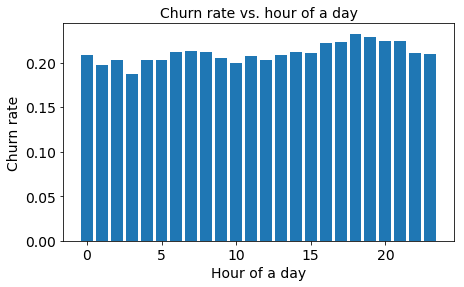

In [33]:
# Calculate hourly counts
hourly = df_sub.select(['userId', 'hour', 'churnUser'])\
    .dropDuplicates()\
    .groupBy('hour')\
    .agg(count('userId').alias('num_users'), Fsum('churnUser').alias('num_churns'))
hourly_df = hourly.toPandas()

# Visualize hourly patterns
plt.figure(figsize=(7,4))
plt.bar(hourly_df['hour'], hourly_df['num_churns']/hourly_df['num_users'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Hour of a day", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)
plt.title("Churn rate vs. hour of a day", fontsize=14);

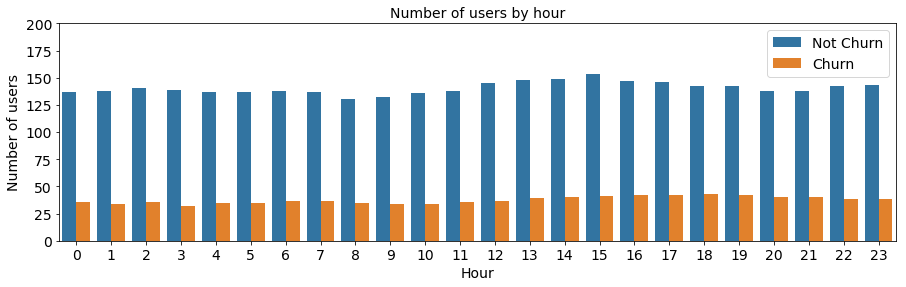

In [34]:
# Visualize the number of users by hour
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
hour_users_pd = df_sub.select(['userId', 'hour', 'churnUser']).dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

fig = plt.figure(figsize=(15, 4))
sns.countplot(x="hour", hue="churnUser", data=hour_users_pd,
              hue_order=['Not Churn', 'Churn']);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 200)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Number of users", fontsize=14)
plt.title("Number of users by hour", fontsize=14)
plt.legend(loc='best', fontsize=14);

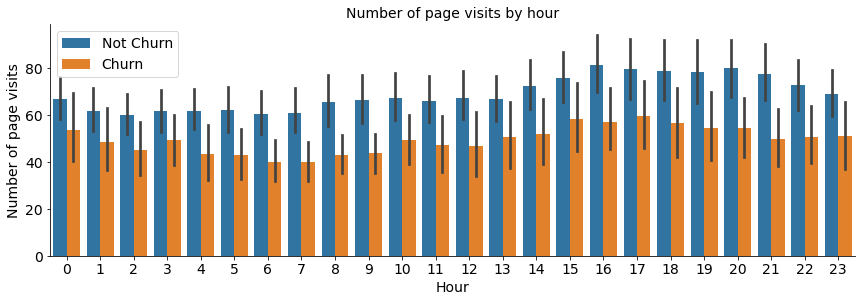

In [35]:
# Visualize the usage (i.e. the number of page events) by hour
hour_usage_pd = df_sub.groupBy(['userId', 'hour']).agg(count('page'), max('churnUser'))\
    .withColumn('max(churnUser)', func_churn_label('max(churnUser)'))\
    .toPandas()

fig = plt.figure(figsize=(15, 4))
sns.factorplot(x="hour", y="count(page)", hue="max(churnUser)", data=hour_usage_pd,
#                palette=['steelblue', 'orange'], ci=None,
               kind="bar", aspect=3, legend=False);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Number of page visits", fontsize=14)
plt.title("Number of page visits by hour", fontsize=14)
plt.legend(loc='best', fontsize=14);

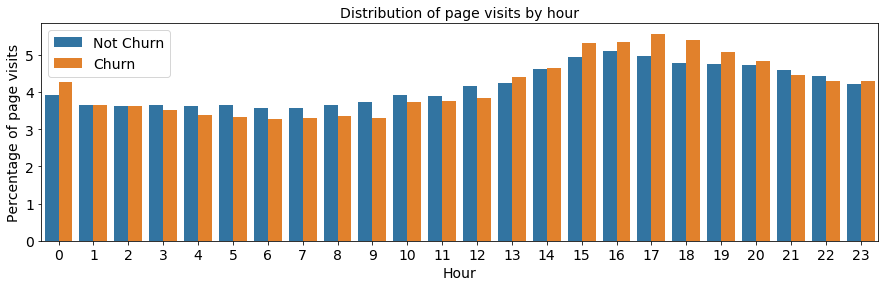

In [36]:
# Visualize the percentage of page events by hour
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

hour_usage_pd = df_sub.withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()
hour_usage_pd = hour_usage_pd.groupby(['churnUser'])['hour']\
    .value_counts(normalize=True).rename('percentage').mul(100).reset_index()

fig = plt.figure(figsize=(15, 4))
sns.barplot(x="hour", y="percentage", hue="churnUser", data=hour_usage_pd,
              hue_order=['Not Churn', 'Churn']);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Percentage of page visits", fontsize=14)
plt.title("Distribution of page visits by hour", fontsize=14)
plt.legend(loc='best', fontsize=14);

#### Churn vs. weekday

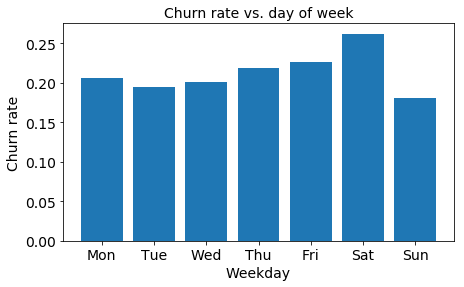

In [37]:
# Calculate day counts
daily = df_sub.select(['userId', 'weekday', 'churnUser'])\
    .dropDuplicates()\
    .groupBy('weekday')\
    .agg(count('userId').alias('num_users'), Fsum('churnUser').alias('num_churns'))
daily_df = daily.toPandas()

# Visualize weekday patterns
plt.figure(figsize=(7,4))
plt.bar(daily_df['weekday'], daily_df['num_churns'] / daily_df['num_users'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Weekday", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title("Churn rate vs. day of week", fontsize=14);

Saturday has highest churn rate. This seems to suggest that the Friday users cohort are more likely to churn.

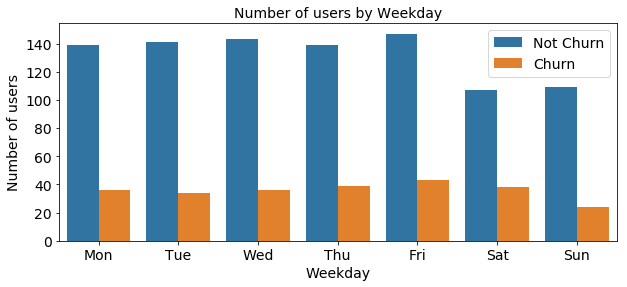

In [38]:
# Visualize the number of users by weekday
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
weekday_users_pd = df_sub.select(['userId', 'weekday', 'churnUser']).dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

fig = plt.figure(figsize=(10, 4))
sns.countplot(x="weekday", hue="churnUser", data=weekday_users_pd,
              hue_order=['Not Churn', 'Churn']);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Weekday", fontsize=14)
plt.ylabel("Number of users", fontsize=14)
plt.title("Number of users by Weekday", fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend(loc='best', fontsize=14);

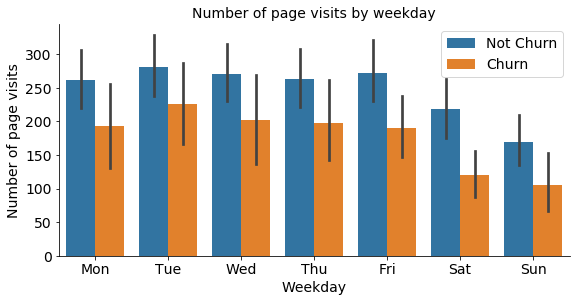

In [39]:
# Visualize the usage (i.e. the number of page events) by weekday
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
weekday_usage_pd = df_sub.groupBy(['userId', 'weekday']).agg(count('page'), max('churnUser'))\
    .withColumn('max(churnUser)', func_churn_label('max(churnUser)'))\
    .toPandas()

fig = plt.figure(figsize=(10, 4))
sns.factorplot(x="weekday", y="count(page)", hue="max(churnUser)", data=weekday_usage_pd,
#                palette=['steelblue', 'orange'], ci=None,
               kind="bar", aspect=2, legend=False);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Weekday", fontsize=14)
plt.ylabel("Number of page visits", fontsize=14)
plt.title("Number of page visits by weekday", fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend(loc='best', fontsize=14);

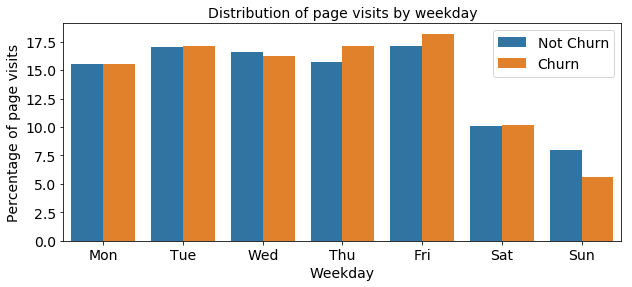

In [40]:
# Visualize the percentage of page events by weekday
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

weekday_usage_pd = df_sub.withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()
weekday_usage_pd = weekday_usage_pd.groupby(['churnUser'])['weekday']\
    .value_counts(normalize=True).rename('percentage').mul(100).reset_index()

fig = plt.figure(figsize=(10, 4))
sns.barplot(x="weekday", y="percentage", hue="churnUser", data=weekday_usage_pd,
              hue_order=['Not Churn', 'Churn']);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Weekday", fontsize=14)
plt.ylabel("Percentage of page visits", fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title("Distribution of page visits by weekday", fontsize=14)
plt.legend(loc='best', fontsize=14);

#### Churn vs. level

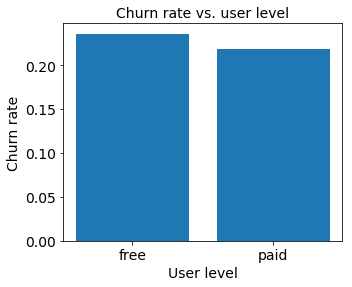

In [41]:
# Calculate churns by level
levels = df_sub.select(['userId', 'level', 'churnUser'])\
    .dropDuplicates()\
    .groupBy('level')\
    .agg(count('userId').alias('num_users'), Fsum('churnUser').alias('num_churns'))
levels_df = levels.toPandas()

# Visualize level patterns
plt.figure(figsize=(5,4))
plt.bar(levels_df['level'], levels_df['num_churns'] / levels_df['num_users'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("User level", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)
plt.title("Churn rate vs. user level", fontsize=14);

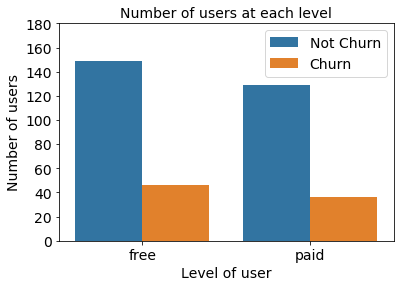

In [42]:
# Visualize the number of users by level
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
level_users_pd = df_sub.select(['userId', 'level', 'churnUser']).dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

fig = plt.figure(figsize=(6, 4))
sns.countplot(x="level", hue="churnUser", data=level_users_pd,
#                palette=['steelblue', 'orange'], ci=None,
);
plt.ylim(0, 180)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Level of user", fontsize=14)
plt.ylabel("Number of users", fontsize=14)
plt.title("Number of users at each level", fontsize=14)
plt.legend(loc='best', fontsize=14);

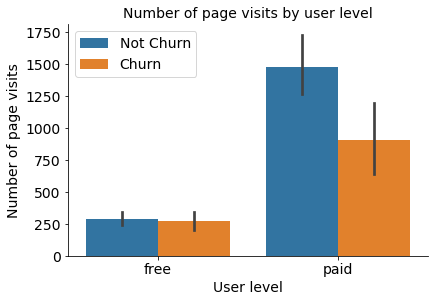

In [43]:
# Visualize the usage (i.e. the number of page events) by level
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
level_usage_pd = df_sub.groupBy(['userId', 'level']).agg(count('page'), max('churnUser'))\
    .withColumn('max(churnUser)', func_churn_label('max(churnUser)'))\
    .toPandas()

fig = plt.figure(figsize=(6, 4))
sns.factorplot(x="level", y="count(page)", hue="max(churnUser)", data=level_usage_pd,
#                palette=['steelblue', 'orange'], ci=None,
               kind="bar", aspect=1.5, legend=False);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("User level", fontsize=14)
plt.ylabel("Number of page visits", fontsize=14)
plt.title("Number of page visits by user level", fontsize=14)
plt.legend(loc='best', fontsize=14);

There are more free users than paid users, and the free users are slightly more likely to churn.

#### Churn vs. page events

In [44]:
# Create pivot table of page events
pages = df_sub.groupBy(['userId']).pivot('page').count().fillna(0)
pages_df = pages.toPandas()

pages_df = pages_df.rename(columns={"Cancellation Confirmation": "Churn"})
pages_df.head()

,userId,About,Add Friend,Add to Playlist,Cancel,Churn,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,3,4,8,0,0,5,0,2,20,5,387,7,0,3,0,1,6,21,2
1,100010,1,4,7,0,0,0,0,2,11,5,275,52,0,0,0,0,5,17,2
2,125,0,0,0,1,1,0,0,0,0,0,8,1,0,0,0,0,0,0,0
3,51,2,28,52,1,1,23,1,12,75,24,2111,0,1,12,0,0,21,100,0
4,124,7,74,118,0,0,41,6,23,176,59,4079,4,6,20,0,0,41,171,0


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


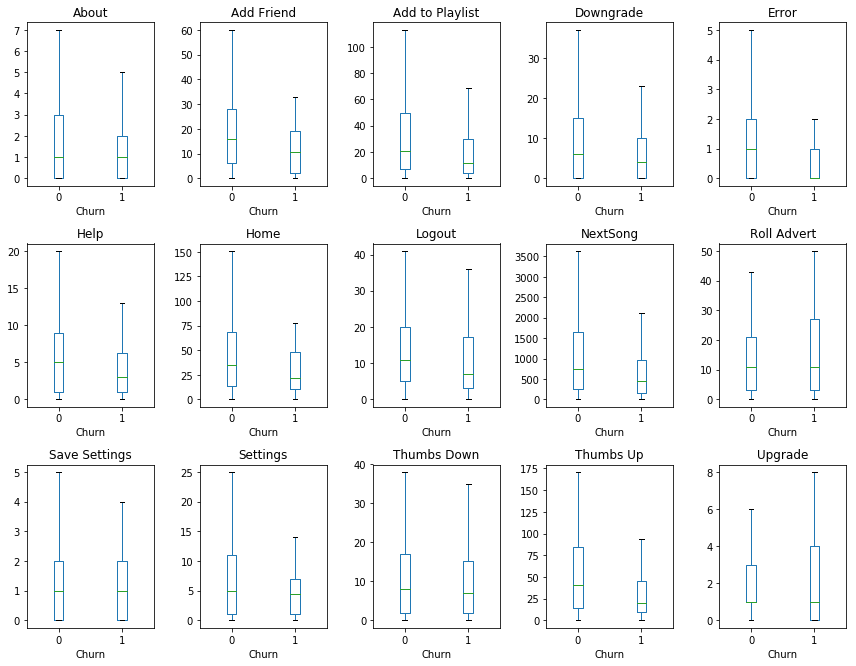

In [45]:
# Visualize churn patterns by page event
fig = plt.figure(figsize=(12, 12))
cols_interest = ['About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 
                 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Thumbs Down', 
                 'Thumbs Up', 'Upgrade']

for i, coln in enumerate(cols_interest):
    ax = fig.add_subplot(4,5,i+1)
    pages_df.boxplot(coln, ax=ax, grid=False,  by='Churn', showfliers=False);

fig.suptitle('')
plt.tight_layout()

In general, churn users have less engagement (number of page events) than no-churn users. Churn users have generally added less friends, added less playlist, requested less help, listened less songs, and given less thumbs ups than thumbs downs. Interestingly, churn users have also encountered less errors, which on a second thought makes sense because churn users genrally engage less with Spotify and have less chances to encounter errors.

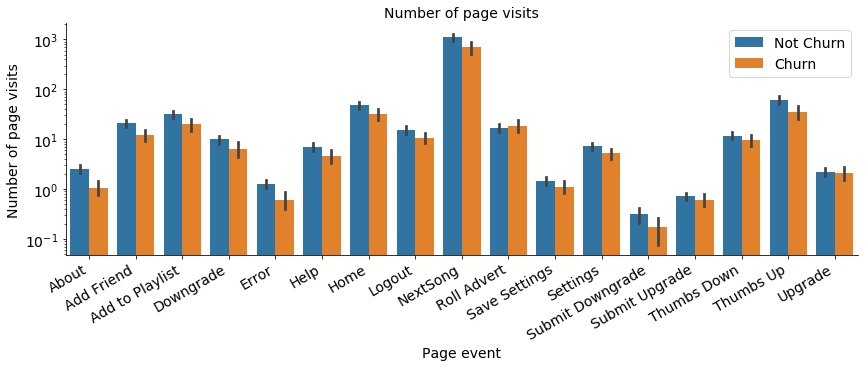

In [46]:
# Visualize the distribution of page events
pages_df['Churn'] = pages_df['Churn'].replace({1: "Churn", 0: "Not Churn"})
pages_df = pages_df.drop('Cancel', axis=1)

page_events_pd = pd.melt(
    pages_df, id_vars=['userId', 'Churn'], 
    value_vars=list(pages_df.columns[1:].drop('Churn')),
    var_name='page', 
    value_name='number_visits'
).reset_index()

fig = plt.figure(figsize=(10, 6))
sns.factorplot(x="page", y="number_visits", hue="Churn", data=page_events_pd,
               kind="bar", aspect=3, legend=False, log=True);
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Page event", fontsize=14)
plt.ylabel("Number of page visits", fontsize=14)
plt.title("Number of page visits", fontsize=14)
plt.legend(loc='best', fontsize=14);

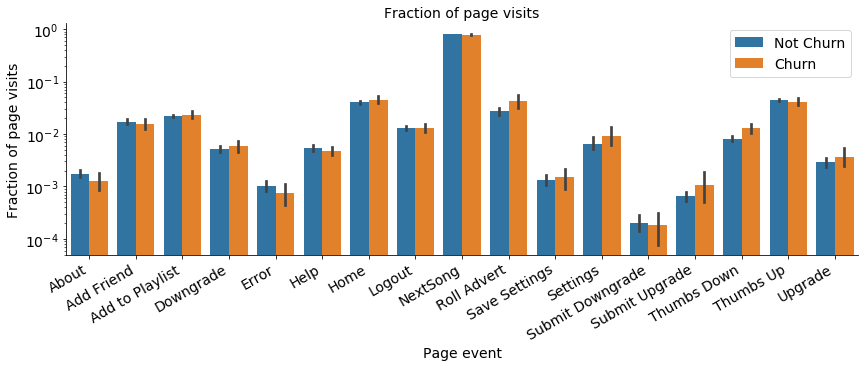

In [47]:
# Visualize the distribution of page events fractions
pages_df['Churn'] = pages_df['Churn'].replace({1: "Churn", 0: "Not Churn"})
# pages_df = pages_df.drop('Cancel', axis=1)

pages_df_frac = pages_df.copy()
event_cols = [coln for coln in pages_df_frac.columns[1:] if coln != 'Churn']
pages_df_frac['total'] = pages_df_frac[event_cols].sum(axis=1)
for coln in event_cols:
    pages_df_frac[coln] = pages_df_frac[coln] / pages_df_frac['total']

page_events_frac_pd = pd.melt(
    pages_df_frac, id_vars=['userId', 'Churn'], 
    value_vars=event_cols,
    var_name='page', 
    value_name='frac_visits'
).reset_index()

fig = plt.figure(figsize=(10, 6))
sns.factorplot(x="page", y="frac_visits", hue="Churn", data=page_events_frac_pd,
               kind="bar", aspect=3, legend=False, log=True);
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Page event", fontsize=14)
plt.ylabel("Fraction of page visits", fontsize=14)
plt.title("Fraction of page visits", fontsize=14)
plt.legend(loc='best', fontsize=14);

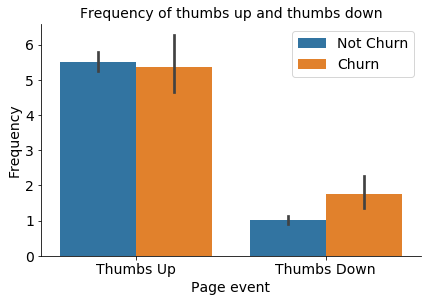

In [48]:
# Visualize the frequency of thumbs up vs. thumbs down
pages_df['Thumbs Up Frequency'] = pages_df['Thumbs Up'] / pages_df['NextSong'] * 100
pages_df['Thumbs Down Frequency'] = pages_df['Thumbs Down'] / pages_df['NextSong'] * 100

page_events_pd2 = pd.melt(
    pages_df[['userId', 'Churn', 'Thumbs Up Frequency', 'Thumbs Down Frequency']], 
    id_vars=['userId', 'Churn'], 
    value_vars=['Thumbs Up Frequency', 'Thumbs Down Frequency'],
    var_name='page', 
    value_name='ratio'
).reset_index()
page_events_pd2['page'] = page_events_pd2['page']\
    .replace({"Thumbs Up Frequency": "Thumbs Up", 
              "Thumbs Down Frequency": "Thumbs Down"})

fig = plt.figure(figsize=(10, 6))
sns.factorplot(x="page", y="ratio", hue="Churn", data=page_events_pd2,
               kind="bar", aspect=1.5, legend=False);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Page event", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Frequency of thumbs up and thumbs down", fontsize=14)
plt.legend(loc='best', fontsize=14);

#### Churn vs. device used

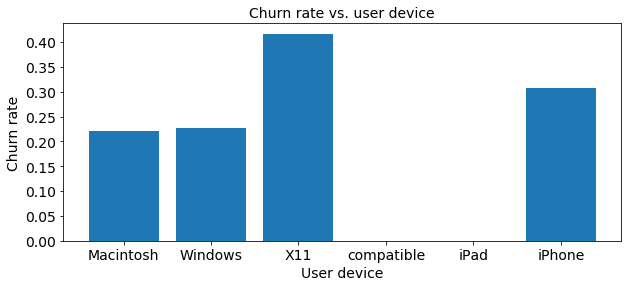

In [49]:
# Calculate churns by device
func_agent_device = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])
df_sub_device = df_sub.withColumn("userAgent", func_agent_device(df_sub["userAgent"]))
df_sub_device.createOrReplaceTempView("df_sub_device_table")

device = df_sub_device.select(['userId', 'userAgent', 'churnUser'])\
    .dropDuplicates()\
    .groupBy('userAgent')\
    .agg(count('userId').alias('num_users'), Fsum('churnUser').alias('num_churns'))
device_df = device.toPandas()

# Visualize device patterns
plt.figure(figsize=(10,4))
plt.bar(device_df['userAgent'], device_df['num_churns'] / device_df['num_users'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("User device", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)
plt.title("Churn rate vs. user device", fontsize=14);

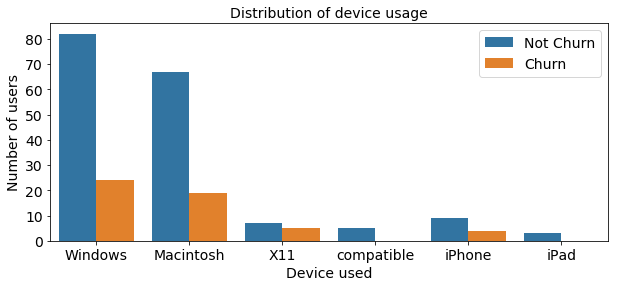

In [50]:
# Calculate churns by device
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
func_agent_device = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

df_sub_device = df_sub.withColumn("userAgent", func_agent_device(df_sub["userAgent"]))
device_pd = df_sub_device.select(["userId", 'userAgent', 'churnUser'])\
    .dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

fig = plt.figure(figsize=(10, 4))
sns.countplot(x="userAgent", hue="churnUser", data=device_pd);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Device used", fontsize=14)
plt.ylabel("Number of users", fontsize=14)
plt.title("Distribution of device usage", fontsize=14)
plt.legend(loc='best', fontsize=14);

#### Churn vs. location

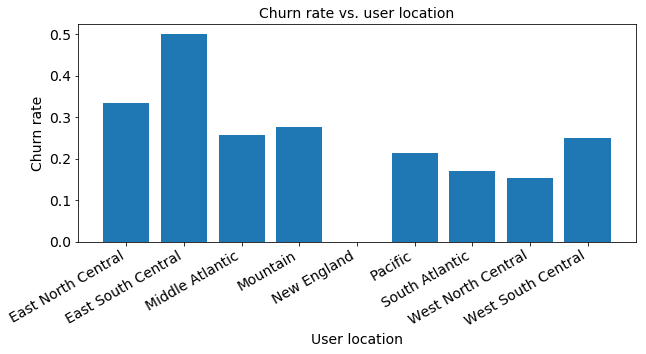

In [51]:
# Find the user's geographical division based on the first listed location state
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
path = "region.csv"
region = spark.read.csv(path, header=True)
func_locations = udf(lambda x: x.split(', ')[1].split('-')[0])

locations = df_sub.withColumn('location', func_locations(df_sub['location']))\
    .select(['userId', 'location', 'churnUser']).dropDuplicates(subset=['userId'])
locations = locations.join(region, locations['location']==region['State Code'], how='left')\
    .select(['userId', col("Division").alias("location"), col("churnUser").alias("churn")])\
    .withColumn('churn', func_churn_label('churn'))
locations_pd = locations.toPandas()

# Visualize device patterns
locations_count = locations_pd.groupby(['location', 'churn']).count().unstack().fillna(0)['userId']
locations_count['total'] = locations_count.sum(axis=1)

plt.figure(figsize=(10,4))
plt.bar(locations_count.index, locations_count['Churn'] / locations_count['total'])
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("User location", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)
plt.title("Churn rate vs. user location", fontsize=14);

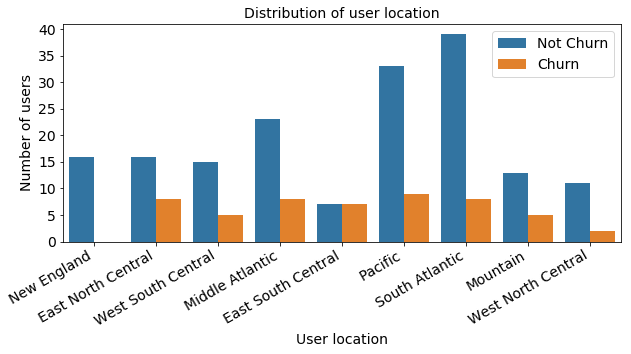

In [52]:
fig = plt.figure(figsize=(10, 4))
sns.countplot(x="location", hue="churn", data=locations_pd,
#                palette=['steelblue', 'orange'], ci=None,
);
plt.xlabel("User location", fontsize=14)
plt.ylabel("Number of users", fontsize=14)
plt.title("Distribution of user location", fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=14);

#### Time from downgrade to churn

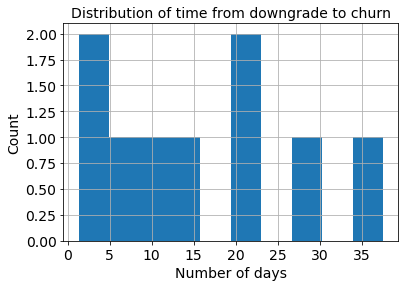

In [53]:
# For those who downgraded and churn, calculate time from downgrade to churn
downgrade_to_churn = df_sub.filter((df_sub['churnUser']==1) & (df_sub['pageDowngradePhase']==1))\
    .groupBy(['userId']).agg(max('ts')-min('ts'))\
    .withColumnRenamed('(max(ts) - min(ts))','timeDownToChurn')

# Report the time from downgrade to churn in hours
hours_to_churn = downgrade_to_churn.withColumn("hourDownToChurn", downgrade_to_churn["timeDownToChurn"]/1000/3600)\
    .select(['userId', 'hourDownToChurn'])
hours_to_churn_pd = hours_to_churn.toPandas()

# Visualie time from downgrade to churn
(hours_to_churn_pd['hourDownToChurn']/24).hist()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Number of days", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of time from downgrade to churn", fontsize=14);

## 3. Feature Engineering

In this section, I'm going to build out the features that I think useful to train my model on. First, I'm going to do pilot study on a small subset of the full dataset. Then, I will use the code on the full dataset.

Choose a subset of the dataset to start with.

In [54]:
# Number of unique userId's to be sampled for exploratory data analysis
user_sample_size = 250

# Unique userId's from the full dataset
users = [row.userId for row in df.select('userId').dropDuplicates().collect()]

# Sample userId's
if len(users) > user_sample_size:
    user_sample = list(np.random.choice(users, size=user_sample_size, replace=False))
else:
    user_sample = list(np.copy(users))

# Create subset of the full dataset
df_sub2 = df.filter(df['userId'].isin(user_sample))
print(f"{df_sub2.select('userId').dropDuplicates().count()} unique userId's.")

225 unique userId's.


### 3.1. Create features on per user basis

Features to create on per user basis:

- `page-Cancellation Confirmation`: Churn (binary)

- `registration` and `ts`: Time since registration in seconds
- `gender`: Gender, "M"->1, "F"->0 (binary)
- `level`: Level of user most recently, "paid"->1, "free"->0 (binary)

- `artist`: Total number of unique artists the user has listened to (int)
- `length`: Total length of songs listened (float)
- `sessionId`: Total number of sessions (int)
- `song`: Total number of songs the user has listened to (int)
- `song`: Total number of unique songs the user has listened to (int)

- `artist` and `song`: Statistics of the number of songs per artist that the user has listened to (float)

- `sessionId` and `ts`: Statistics of the time spent per session (float)
- `sessionId` and `song`: Statistics of the number of songs per session (float)

- `userAgent`: User agents (binary)
- `page`: Number of page events (int)
    - Thumbs Up, Thumbs Down, Home, Roll Advert, Logout, Save Settings, About, Settings, Add to Playlist, Add Friend, NextSong, Help, Error, Submit Upgrade, Submit Downgrade
- `location`: First listed location state (binary)

In [55]:
df_sub2.createOrReplaceTempView("df_sub2_table")

#### Define churn

In [56]:
# Define churn
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
churn = df_sub2.withColumn("churned", flag_churn_event("page"))\
    .select(['userId', 'churned'])\
    .groupBy('userId').agg(max('churned').alias("churn"))

print(f"{churn.count()} rows.")
print(f"{round(churn.select(avg('churn')).collect()[0]['avg(churn)']*100, 1)}% users churned.")
churn.show(5)

225 rows.
23.1% users churned.
+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|    51|    1|
|   124|    0|
+------+-----+
only showing top 5 rows



#### Latest level of user

In [57]:
# Latest level
func_levels = udf(lambda x: 1 if x=="paid" else 0, IntegerType())
levels = df_sub2.select(['userId', 'level', 'ts'])\
    .orderBy(desc('ts'))\
    .dropDuplicates(['userId'])\
    .select(['userId', 'level'])\
    .withColumn('level', func_levels('level').cast(IntegerType()))

print(f"{levels.count()} rows.")
levels.show(5)

225 rows.
+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    1|
|   125|    0|
|   124|    1|
|    51|    1|
+------+-----+
only showing top 5 rows



#### Time since registration, and gender of user

In [58]:
# Time since registration in seconds, and gender as binary
time_gender = spark.sql(
    '''
    SELECT userId, (MAX(ts) - AVG(registration)) / 1000 time_since_regi,
    AVG(CASE WHEN gender = "M" THEN 1 ELSE 0 END) gender
    FROM df_sub2_table
    GROUP BY userId
    '''
)

print(f"{time_gender.count()} rows.")
time_gender.show(5)

225 rows.
+------+---------------+------+
|userId|time_since_regi|gender|
+------+---------------+------+
|100010|      4807612.0|   0.0|
|200002|      6054448.0|   1.0|
|   125|      6161779.0|   1.0|
|    51|      1680985.0|   1.0|
|   124|    1.1366431E7|   0.0|
+------+---------------+------+
only showing top 5 rows



#### Number of artists, total length, number of sessions, and number of songs that the user has engaged

In [59]:
# Number of artists, total length, number of sessions, number of songs, and number of page events
# that the user has engaged
engagement = spark.sql(
    '''
    SELECT userId, COUNT(DISTINCT artist) num_artists_dist, 
    SUM(length) tot_length, COUNT(DISTINCT sessionId) num_sessions, 
    COUNT(song) num_songs, COUNT(DISTINCT song) num_songs_dist,
    COUNT(page) num_events
    FROM df_sub2_table
    GROUP BY userId
    '''
)

print(f"{engagement.count()} rows.")
engagement.show(5)

225 rows.
+------+----------------+------------------+------------+---------+--------------+----------+
|userId|num_artists_dist|        tot_length|num_sessions|num_songs|num_songs_dist|num_events|
+------+----------------+------------------+------------+---------+--------------+----------+
|100010|             252| 66940.89735000003|           7|      275|           269|       381|
|200002|             339| 94008.87593999993|           6|      387|           378|       474|
|   125|               8|2089.1131000000005|           1|        8|             8|        11|
|   124|            2232|1012312.0927899999|          29|     4079|          3339|      4825|
|    51|            1385| 523275.8428000004|          10|     2111|          1854|      2464|
+------+----------------+------------------+------------+---------+--------------+----------+
only showing top 5 rows



#### Statistics of the number of songs per artist that the user has listened to

In [60]:
# Statistics of the number of songs per artist that the user has listened to
per_artist = spark.sql(
    '''
    SELECT userId, MAX(num_songs) max_songs_per_artist, 
    AVG(num_songs) avg_songs_per_artist, stddev_samp(num_songs) std_songs_per_artist
    FROM
        (SELECT userId, artist, COUNT(song) as num_songs
        FROM df_sub2_table
        WHERE (artist IS NOT NULL)
        GROUP BY userId, artist) songs_per_artist
    GROUP BY userId
    '''
).fillna(0)

print(f"{per_artist.count()} rows.")
per_artist.show(5)

225 rows.
+------+--------------------+--------------------+--------------------+
|userId|max_songs_per_artist|avg_songs_per_artist|std_songs_per_artist|
+------+--------------------+--------------------+--------------------+
|100010|                   3|  1.0912698412698412|  0.3273751314568489|
|200002|                   4|  1.1415929203539823|  0.4255297423289412|
|   125|                   1|                 1.0|                 0.0|
|    51|                  15|  1.5241877256317689|  1.4120250777606447|
|   124|                  37|  1.8275089605734767|   2.373901024354072|
+------+--------------------+--------------------+--------------------+
only showing top 5 rows



#### Statistics of the time spent and the number of songs per session

In [61]:
# Statistics of the time spent and the number of songs per session (float)
per_session = spark.sql(
    '''
    SELECT userId, MAX(num_songs) max_songs_per_session, 
    AVG(num_songs) avg_songs_per_session, stddev_samp(num_songs) std_songs_per_session,
    MAX(time) max_time_per_session, AVG(time) avg_time_per_session, 
    stddev_samp(time) std_time_per_session
    FROM
        (SELECT userId, sessionId, (MAX(ts) - MIN(ts))/1000 AS time, COUNT(song) num_songs
        FROM df_sub2_table
        GROUP BY userId, sessionId) per_session
    GROUP BY userId
    '''
).fillna(0)

print(f"{per_session.count()} rows.")
per_session.show(5)

225 rows.
+------+---------------------+---------------------+---------------------+--------------------+--------------------+--------------------+
|userId|max_songs_per_session|avg_songs_per_session|std_songs_per_session|max_time_per_session|avg_time_per_session|std_time_per_session|
+------+---------------------+---------------------+---------------------+--------------------+--------------------+--------------------+
|100010|                   80|   39.285714285714285|    22.96166577663945|             19380.0|              9269.0|   5719.952913559108|
|200002|                  120|                 64.5|   51.309843110264914|             29847.0|             15984.0|  13016.721707096607|
|   125|                    8|                  8.0|                  0.0|              1774.0|              1774.0|                 0.0|
|    51|                  497|                211.1|    168.1483802413148|            124163.0|             52341.4|    42019.1732088526|
|   124|                

#### Calculate usage of each userAgent

In [62]:
# Calculate usage fraction of each userAgent
window = Window.partitionBy("userId").rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
func_agent_device = udf(lambda x: "user_agent_"+x.split('(')[1].replace(";", " ").split(" ")[0])

agents = df_sub2.withColumn("userAgent", func_agent_device(df_sub2["userAgent"]))\
    .select(["userId", 'userAgent'])\
    .groupBy(["userId", 'userAgent'])\
    .agg(count("userAgent").alias("user_agent_usage"))\
    .withColumn('total', Fsum(col('user_agent_usage')).over(window))\
    .withColumn('user_agent_usage', col('user_agent_usage')/col('total'))\
    .groupBy("userId").pivot("userAgent").sum("user_agent_usage").fillna(0)

print(f"{agents.count()} rows.")
agents.show(5)

225 rows.
+------+--------------------+------------------+--------------+---------------------+---------------+-----------------+
|userId|user_agent_Macintosh|user_agent_Windows|user_agent_X11|user_agent_compatible|user_agent_iPad|user_agent_iPhone|
+------+--------------------+------------------+--------------+---------------------+---------------+-----------------+
|100010|                 0.0|               0.0|           0.0|                  0.0|            0.0|              1.0|
|200002|                 0.0|               0.0|           0.0|                  0.0|            0.0|              1.0|
|   125|                 1.0|               0.0|           0.0|                  0.0|            0.0|              0.0|
|   124|                 1.0|               0.0|           0.0|                  0.0|            0.0|              0.0|
|    51|                 0.0|               1.0|           0.0|                  0.0|            0.0|              0.0|
+------+--------------------+-

#### Calculate the count and fraction of each page event by each user

In [63]:
# Count usages of each page event by each user
pages_to_exclude = ['Cancel', 'Downgrade', 'Cancellation Confirmation', 'Upgrade']
func_pages = udf(lambda x: "page_"+x.replace(" ", "_").lower())

pages = df_sub2.filter(~df_sub2['page'].isin(pages_to_exclude))\
    .withColumn("page", func_pages(df_sub2["page"]))\
    .groupBy(['userId']).pivot("page").agg(count('page'))\
    .fillna(0)
pages = pages.withColumn("page_up_down_ratio", pages["page_thumbs_up"]/(pages['page_thumbs_down']+0.1))

print(f"{pages.count()} rows.")
pages.show(2)

225 rows.
+------+----------+---------------+--------------------+----------+---------+---------+-----------+-------------+----------------+------------------+-------------+---------------------+-------------------+----------------+--------------+------------------+
|userId|page_about|page_add_friend|page_add_to_playlist|page_error|page_help|page_home|page_logout|page_nextsong|page_roll_advert|page_save_settings|page_settings|page_submit_downgrade|page_submit_upgrade|page_thumbs_down|page_thumbs_up|page_up_down_ratio|
+------+----------+---------------+--------------------+----------+---------+---------+-----------+-------------+----------------+------------------+-------------+---------------------+-------------------+----------------+--------------+------------------+
|200002|         3|              4|                   8|         0|        2|       20|          5|          387|               7|                 0|            3|                    0|                  1|              

In [64]:
# Calculate the fraction of each page event by each user
pages = pages.withColumn(
    'total', sum(pages[coln] for coln in pages.columns if coln not in ['userId', 'page_up_down_ratio'])
)

for coln in pages.columns:
    if coln not in ['userId', 'total', 'page_up_down_ratio']:
        new_col_name = coln[0:5]+'frac_'+coln[5:]
        pages = pages.withColumn(new_col_name, pages[coln] / pages['total'])

pages = pages.drop('total')
print(f"{pages.count()} rows.")
pages.select([coln for coln in pages.columns if '_frac' in coln]).show(2)

225 rows.
+--------------------+--------------------+-------------------------+---------------+--------------------+--------------------+--------------------+------------------+---------------------+-----------------------+--------------------+--------------------------+------------------------+---------------------+--------------------+
|     page_frac_about|page_frac_add_friend|page_frac_add_to_playlist|page_frac_error|      page_frac_help|      page_frac_home|    page_frac_logout|page_frac_nextsong|page_frac_roll_advert|page_frac_save_settings|  page_frac_settings|page_frac_submit_downgrade|page_frac_submit_upgrade|page_frac_thumbs_down| page_frac_thumbs_up|
+--------------------+--------------------+-------------------------+---------------+--------------------+--------------------+--------------------+------------------+---------------------+-----------------------+--------------------+--------------------------+------------------------+---------------------+--------------------+


#### Find the first listed location region of each user

In [65]:
# # Load open source table that links state names to geographical divisions
# region = pd.read_csv('https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv')
# region.to_csv("region.csv", index=False)
# region.head()

In [66]:
# Load open source table that links state names to geographical divisions
path = "region.csv"
region = spark.read.csv(path, header=True)
region.show(5)

+----------+----------+------+------------------+
|     State|State Code|Region|          Division|
+----------+----------+------+------------------+
|    Alaska|        AK|  West|           Pacific|
|   Alabama|        AL| South|East South Central|
|  Arkansas|        AR| South|West South Central|
|   Arizona|        AZ|  West|          Mountain|
|California|        CA|  West|           Pacific|
+----------+----------+------+------------------+
only showing top 5 rows



In [67]:
# Find the user's geographical division based on the first listed location state
func_locations = udf(lambda x: x.split(', ')[1].split('-')[0])
func_location_names = udf(lambda x: "location_"+x.replace(" ", "_").lower())

locations = df_sub2.withColumn('location', func_locations(df_sub2['location']))\
    .select(['userId', 'location']).dropDuplicates(subset=['userId'])

locations = locations.join(region, locations['location']==region['State Code'], how='left')\
    .select(['userId', col("Division").alias("location")])\
    .withColumn('location', func_location_names('location'))

locations = locations.groupBy('userId').pivot('location').agg(count('location')).fillna(0)

print(f"{locations.count()} rows.")
locations.show(2)

225 rows.
+------+---------------------------+---------------------------+------------------------+-----------------+--------------------+----------------+-----------------------+---------------------------+---------------------------+
|userId|location_east_north_central|location_east_south_central|location_middle_atlantic|location_mountain|location_new_england|location_pacific|location_south_atlantic|location_west_north_central|location_west_south_central|
+------+---------------------------+---------------------------+------------------------+-----------------+--------------------+----------------+-----------------------+---------------------------+---------------------------+
|100010|                          0|                          0|                       0|                0|                   1|               0|                      0|                          0|                          0|
|200002|                          1|                          0|                      

#### Join engineered features together

In [68]:
dataset = churn.join(levels, ['userId'])\
    .join(time_gender, ['userId'])\
    .join(engagement, ['userId'])\
    .join(per_artist, ['userId'])\
    .join(per_session, ['userId'])\
    .join(agents, ['userId'])\
    .join(pages, ['userId'])\
    .join(locations, ['userId'])

dataset.head()

Row(userId='100010', churn=0, level=0, time_since_regi=4807612.0, gender=0.0, num_artists_dist=252, tot_length=66940.89735000003, num_sessions=7, num_songs=275, num_songs_dist=269, num_events=381, max_songs_per_artist=3, avg_songs_per_artist=1.0912698412698412, std_songs_per_artist=0.3273751314568489, max_songs_per_session=80, avg_songs_per_session=39.285714285714285, std_songs_per_session=22.96166577663945, max_time_per_session=19380.0, avg_time_per_session=9269.0, std_time_per_session=5719.952913559108, user_agent_Macintosh=0.0, user_agent_Windows=0.0, user_agent_X11=0.0, user_agent_compatible=0.0, user_agent_iPad=0.0, user_agent_iPhone=1.0, page_about=1, page_add_friend=4, page_add_to_playlist=7, page_error=0, page_help=2, page_home=11, page_logout=5, page_nextsong=275, page_roll_advert=52, page_save_settings=0, page_settings=0, page_submit_downgrade=0, page_submit_upgrade=0, page_thumbs_down=5, page_thumbs_up=17, page_up_down_ratio=3.3333333333333335, page_frac_about=0.002638522427

## 4. Modeling

## 5. Final Steps